In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import cv2

import os
import re

import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertModel

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [22]:
df = pd.read_csv('MELD.Raw/train_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")

optimizer = 'rmsprop'
loss = 'categorical_crossentropy'
batch_size = 64
metrics = ['accuracy']

emotions = df.Sentiment.unique()
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    verbose=1,           
    restore_best_weights=True
)


In [23]:
min_size = df.Sentiment.value_counts().min()

dataframes = []

for emotion in df.Sentiment.unique():
    dataframes.append(df[df.Sentiment == emotion].sample(min_size, ignore_index=True))

df = pd.concat(dataframes, ignore_index=True)             #uncomment for balancing
df = df.sample(frac=0.05, ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1951,"Okay, great.",Rachel,joy,positive,195,2,3,5,"00:18:40,869","00:18:42,370"
1,6527,"Yeah, I know. He can get really competitive.",Monica,neutral,neutral,650,1,1,18,"00:08:38,601","00:08:41,019"
2,1718,Oh..please!I-I welcome criticism.,Monica,neutral,neutral,174,5,9,19,"00:06:10,871","00:06:15,501"
3,6937,"Oh, you have been through so much.",Monica,sadness,negative,680,13,6,18,"00:09:28,818","00:09:30,402"
4,9247,You do attract some stinkers.,Joey,sadness,negative,924,6,8,23,"00:16:31,562","00:16:34,815"
...,...,...,...,...,...,...,...,...,...,...,...
345,2744,What am I gonna do?!,Joey,fear,negative,274,8,4,22,"0:10:27,210","0:10:28,113"
346,4218,"Yeah, all of us! All day!",Joey,joy,positive,431,8,5,2,"00:14:49,680","00:14:51,264"
347,3377,They call me: 'Cookie Dude!',Ross,joy,positive,336,18,3,10,"00:13:25,304","00:13:28,973"
348,1922,I'm marrying her.,Chandler,joy,positive,190,6,7,5,"00:21:44,469","00:21:46,012"


In [24]:
# face_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
#                                         include_top=False,
#                                         weights="imagenet") #include_top=True for predictions, False for embeddings

In [25]:
from keras_vggface.vggface import VGGFace

# VGGFace model
face_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')


In [26]:
import sys

def find_largest_global():
    largest_var_name = None
    largest_size = 0

    for var_name, var_value in globals().items():
        # Skip built-in modules and functions
        if not var_name.startswith('__') and not callable(var_value):
            size = sys.getsizeof(var_value)
            if size > largest_size:
                largest_size = size
                largest_var_name = var_name

    return largest_var_name, largest_size

The following produces detector embeddings without the use of a NN model.

In [27]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [28]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (1,224,224,3))]
split_size = int(len(df) * 0.8)



In [29]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                .strip() for txt in df['Utterance']]

C:\Users\gsevr\AppData\Local\Temp\ipykernel_17760\2616501896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])


In [30]:
ohe = OneHotEncoder(categories=[emotions])
labels = ohe.fit_transform(df.Sentiment.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [31]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]
del df

The following uses detector embeddings to fine tune the VGG16 model

In [32]:
#this includes transfer learning for vgg16 and makes predictions based on that.

for layer in face_model.layers:
    layer.trainable=False

for layer in face_model.layers[-4:]:
    layer.trainable = True

base = face_model.output

flat = Flatten(name="flatten")(base)
fc1 = (Dense(512, activation='relu'))(flat)
drop1 = (Dropout(0.3))(fc1)
fc2 = (Dense(256, activation='relu'))(drop1)
drop2 = (Dropout(0.3))(fc2)
fc3 = (Dense(128, activation='relu'))(drop2)
drop3 = (Dropout(0.3))(fc3)
fc4 = (Dense(64, activation='relu'))(drop3)
drop4 = (Dropout(0.3))(fc4)
output = (Dense(len(emotions), activation='softmax'))(drop4)
vid_pred_model = Model(inputs=face_model.input,outputs=output)

vid_pred_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,224,224,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

In [33]:
history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=20, validation_data=(vid_val,labels_val), batch_size=batch_size)

Epoch 1/20
4/4 [==============================] - 104s 26s/step - loss: 1.1008 - accuracy: 0.3402 - val_loss: 1.0970 - val_accuracy: 0.3387
Epoch 2/20
1/4 [======>.......................] - ETA: 1:15 - loss: 1.0985 - accuracy: 0.3125

KeyboardInterrupt: 

NameError: name 'history_vid_pred' is not defined

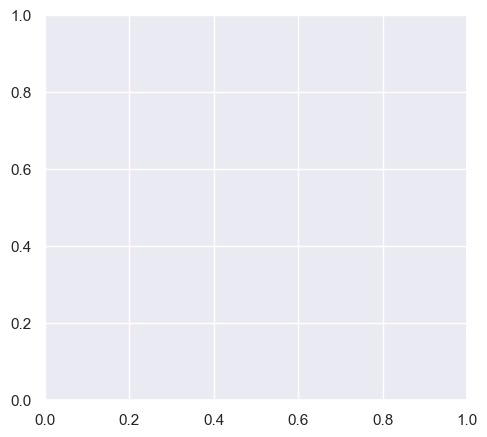

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'])
plt.plot(history_vid_pred.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'])
plt.plot(history_vid_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [35]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)


2/2 [==============================] - 6s 3s/step


In [36]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-4]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [50]:
#THIS GETS PREDICTIONS for text

from transformers import AutoTokenizer, TFDistilBertModel

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFDistilBertModel.from_pretrained(model_name, num_labels=len(emotions))

input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
token_type_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

bert_outputs = model(
    input_ids=input_ids,
    # token_type_ids=token_type_ids,
    attention_mask=attention_mask
)

pooled_output = bert_outputs.last_hidden_state[:, 0]
dense_layer = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
less_dense = tf.keras.layers.Dense(16, activation='relu')(dense_layer)
output_layer = tf.keras.layers.Dense(len(emotions), activation='softmax')(less_dense)


text_pred_model = tf.keras.Model(
    inputs=[input_ids, 
            # token_type_ids,
            attention_mask],
    outputs=output_layer
)


# Data and labels
train_texts = list(df_train.prepro.values)
train_labels = list(labels_train)

val_texts = list(df_val.prepro.values)
val_labels = list(labels_val)

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf')

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)


# Split inputs
train_inputs = {
    'input_ids': np.array(train_encodings['input_ids']),
    # 'token_type_ids': np.array(train_encodings['token_type_ids']),
    'attention_mask': np.array(train_encodings['attention_mask'])
}

val_inputs = {
    'input_ids': np.array(val_encodings['input_ids']),
    # 'token_type_ids': np.array(val_encodings['token_type_ids']),
    'attention_mask': np.array(val_encodings['attention_mask'])
}

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_inputs,
    train_labels
)).shuffle(len(train_inputs)).batch(batch_size,drop_remainder=True)  # Adjust batch size as needed. will return error if batch_size > len(train_inputs)

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_inputs,
    val_labels
)).shuffle(len(val_inputs)).batch(batch_size,drop_remainder=True)


# Optimizer and loss function
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compiling
text_pred_model.compile(optimizer=optimizer, loss=loss, metrics=metrics, run_eagerly=True)

# Fine-tuning
history_text_pred = text_pred_model.fit(train_dataset, epochs=20, validation_data=(val_dataset), batch_size=batch_size)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/20
3/3 [==============================] - 15s 6s/step - loss: 1.4208 - accuracy: 0.3594 - val_loss: 1.1906 - val_accuracy: 0.3667
Epoch 2/20
3/3 [==============================] - 15s 6s/step - loss: 1.1468 - accuracy: 0.3646 - val_loss: 1.1015 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 16s 6s/step - loss: 1.1153 - accuracy: 0.3333 - val_loss: 1.1032 - val_accuracy: 0.3667
Epoch 4/20
3/3 [==============================] - 16s 6s/step - loss: 1.1019 - accuracy: 0.3385 - val_loss: 1.1039 - val_accuracy: 0.3000
Epoch 5/20
3/3 [==============================] - 17s 6s/step - loss: 1.0988 - accuracy: 0.3229 - val_loss: 1.1074 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 17s 6s/step - loss: 1.1065 - accuracy: 0.3281 - val_loss: 1.1013 - val_accuracy: 0.3667
Epoch 7/20
3/3 [==============================] - 17s 6s/step - loss: 1.1058 - accuracy: 0.3385 - val_loss: 1.0987 - val_accuracy: 0.3667
Epoch 8/20
3/3 [==================

KeyboardInterrupt: 

In [49]:
val_labels

<tf.Tensor: shape=(62, 3), dtype=float64, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
      

NameError: name 'history_text_pred' is not defined

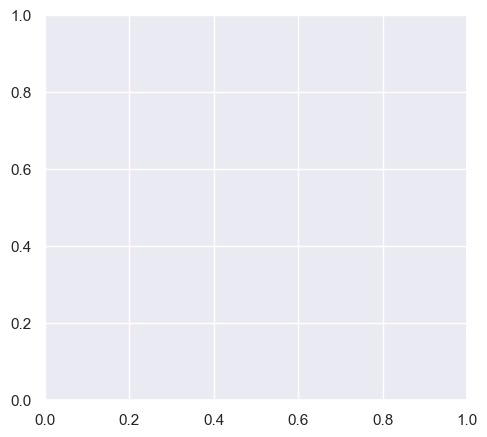

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_text_pred.history['loss'])
plt.plot(history_text_pred.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_text_pred.history['accuracy'])
plt.plot(history_text_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [ ]:
#Prediction format

input_texts = df_val.Utterance.values 

input_encodings = tokenizer.batch_encode_plus(input_texts, truncation=True, padding='max_length', max_length=16, return_tensors="tf")

text_predictions = text_pred_model.predict({
    'input_ids': input_encodings['input_ids'],
    'token_type_ids': input_encodings['token_type_ids'],
    'attention_mask': input_encodings['attention_mask']
})

predicted_emotions = np.argmax(text_predictions, axis=1)


predicted_emotion_labels = [emotions[idx] for idx in predicted_emotions]

for text, label in zip(input_texts, predicted_emotion_labels):
    print(f"Text: {text}, Predicted emotion: {label}")



11/11 [==============================] - 41s 4s/step
Text: Yeah.  Hi Mark!, Predicted emotion: anger
Text: Oh good, you're here. Yeah, and I was worried that it was going to be uncomfortable., Predicted emotion: anger
Text: Oh, be-because of the leather pants., Predicted emotion: anger
Text: Hello? Who are we spying on?, Predicted emotion: anger
Text: And we'll be like, 'Man get over it, it's been four years!!', Predicted emotion: anger
Text: Okay, so if an eight comes up, we take it as a sign and we do it!, Predicted emotion: anger
Text: I'm sorry, so umm, so where are we?, Predicted emotion: anger
Text: And did you?!, Predicted emotion: anger
Text: F-hah.... flennin...., Predicted emotion: anger
Text: Mom, c'mon, stop worrying., Predicted emotion: anger
Text: Oh please, he didn't hear it! He didn't hear it!!, Predicted emotion: anger
Text: Sweetheart, just gimme- gimme another chance, okay, we'll start all over again. We'll go back to Aruba., Predicted emotion: anger
Text: Thank you!

In [ ]:
# THIS GETS EMBEDDINGS

text_embeddings_model = tf.keras.Model(inputs=text_pred_model.input, outputs=bert_outputs.last_hidden_state)

text_embeddings = text_embeddings_model.predict(val_inputs)



11/11 [==============================] - 15s 1s/step


In [ ]:
# con_ten = []
# video_embeddings_array = np.array([embedding for embedding in one_face_videos.values() if embedding != 'too many faces'])

# for i in range(len(df)):
#     con_ten.append(np.concatenate([text_embeddings.ravel(),video_embeddings_array.ravel()]))

# df['concat'] = con_ten

con_ten = []
video_embeddings_array = tf.reduce_mean([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])

for i in range(len(df)):
    con_ten.append(np.concatenate([text_embeddings.ravel(),video_embeddings_array.ravel()]))



C:\Users\gsevr\AppData\Local\Temp\ipykernel_32844\878274344.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['concat'] = con_ten


In [ ]:
fusion_data = np.squeeze(np.array([con_ten],dtype=np.float16))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [ ]:
# Model for early fusion

fusion_model = Sequential()


fusion_model.add(Dense(256, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(emotions), activation='softmax'))

fusion_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=20, validation_data=(fusion_val,labels_val), batch_size=batch_size)

MemoryError: Unable to allocate 24.1 GiB for an array with shape (1332, 9718273) and data type float16

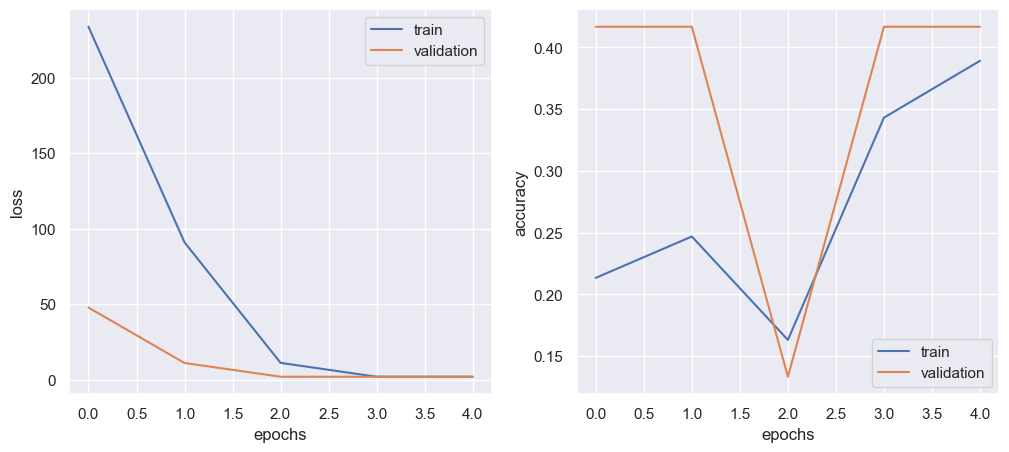

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fusion_model_history.history['loss'])
plt.plot(fusion_model_history.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(fusion_model_history.history['accuracy'])
plt.plot(fusion_model_history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [ ]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions):
    final_predictions = []
    emotions = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust','anger']

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = emotions[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = emotions[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = emotions[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [ ]:
late_fusion_predictions = final_preds(text_predictions, video_predictions)

#TODO Confusion matrix

Equal predictions
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Text: 0.367081880569458, Visual: 0.7571742534637451
Visual wins
Text: 0.41840022802352905, Visual: 0.759676456451416
Visual wins
Equal predictions
Equal predictions
Equal predictions
Text: 0.28368330001831055, Visual: 0.6999790668487549
Visual wins
Text: 0.40563035011291504, Visual: 0.912135660648346
Visual wins
Text: 0.39597031474113464, Visual: 0.6630384922027588
Visual wins
Equal predictions
Equal predictions
Text: 0.3976110517978668, Visual: 0.9491368532180786
Visual wins
Equal predictions
Equal predictions
Text: 0.40249103307724, Visual: 0.3414492905139923
Text wins
Text: 0.37526875734329224, Visual: 0.7435258626937866
Visual wins
Text: 0.39662525057792664, Visual: 0.7216789722442627
Visual wins
Text: 0.37417879700660706, Visual: 0.8367129564285278
Visual wins
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Text: 0.34127622842788696,

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(df_val.Emotion.values, late_fusion_predictions)

0.4